## Setup database connectivity

We'll reuse our module from the previous notebook (***`database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [5]:
%run 'database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [6]:
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

#### Example sensor data creation: we will assume that we have an object that has a linear motion in both x and y coordinates of the catersian space and that we have a sensor that measures the 2-D location (x,y) of the object. Further, we will assume that the sensor measurements are corrupted by additive white Gaussian noise. An example of the sensor measurements for 100 time points (time point 0 is the start of the motion) is shown below.

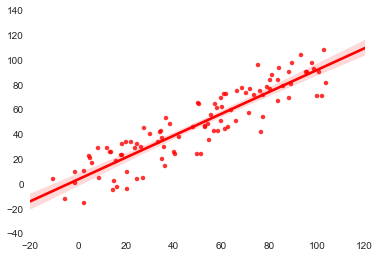

In [8]:
sensor1_times = np.arange(0,100)
sigma = round(5 + 5*np.random.uniform(0,1,1)) # pick a std. deviation for the noise in range [5,10]
sensor1_x = np.arange(0,100) + np.random.normal(0,sigma,100)
sensor1_y = np.arange(0,100) + np.random.normal(0,sigma,100)
sns.regplot(sensor1_x,sensor1_y,color='r')
plt.show()

#### We will now create the sensor input table for the Kalman filter in our MPP database (Greenplum or HAWQ)

In [9]:
sql = """
    DROP TABLE IF EXISTS iot.plpy_kalman_input_one_sensor;
"""
psql.execute(sql,conn)

sql = """
    CREATE TABLE iot.plpy_kalman_input_one_sensor (        
        run_number int,
        sensor1_times float8[],
        sensor1_x float8[],
        sensor1_y float8[]
    ) DISTRIBUTED BY (run_number);
"""
psql.execute(sql,conn)
conn.commit()

#### Insert 50 rows into the Kalman filter input table with each row comprising the time points and the corresponding x and y coordinates of an object measured by a sesnor.

In [10]:
for i in np.arange(1,51):
    sensor1_times = np.arange(0,100)
    sigma = round(5+5*np.random.uniform(0,1,1))
    sensor1_x = np.arange(0,100) + np.random.normal(0,sigma,100)
    sensor1_y = np.arange(0,100) + np.random.normal(0,sigma,100)
    sql = """
        INSERT INTO iot.plpy_kalman_input_one_sensor VALUES (
            {run_number},
            array{s1_times},
            array{s1_x},
            array{s1_y}
        );
    """.format(
            run_number=str(i),
            s1_times = str(sensor1_times.tolist()),
            s1_x = str(sensor1_x.tolist()),
            s1_y = str(sensor1_y.tolist())
        )
    psql.execute(sql,conn)
conn.commit()

#### We will now create the PL/Python User Defined Function for the Kalman Filter in our MPP Database (Greenplum or HAWQ)

In [11]:
# First create a user defined type that is used to return the results of the Kalman filter 
sql = """
    DROP TYPE IF EXISTS iot.kalman_filter_return_type CASCADE;
"""
psql.execute(sql,conn)

sql = """
    CREATE TYPE iot.kalman_filter_return_type AS (
        ts float8,
        x float8,
        y float8
    );
"""
psql.execute(sql,conn)

sql = """
    DROP FUNCTION IF EXISTS iot.plpy_kalmanfilter(
        float8[], 
        float8[], 
        float8[]
    );
"""
psql.execute(sql,conn)

sql = """
    CREATE or REPLACE FUNCTION iot.plpy_kalmanfilter(
        sensor_times float8[], 
        sensor_x float8[], 
        sensor_y float8[]
    )
    RETURNS SETOF iot.kalman_filter_return_type
    AS $$
        import numpy as np
        from numpy import ma
        from pykalman import KalmanFilter
        t1 = np.asarray(sensor_times,dtype=int)
        min_time = np.amin(t1)
        max_time = np.amax(t1)
        init_x = float(np.asarray(sensor_x)[t1==min_time][0])
        init_y = float(np.asarray(sensor_y)[t1==min_time][0])
        resampled_times = np.arange(0,max_time+1)
        resampled_x = ma.array([ma.masked]*(len(resampled_times)))
        resampled_y = ma.array([ma.masked]*(len(resampled_times)))
        resampled_x[t1] = sensor_x
        resampled_y[t1] = sensor_y
        t1_mask = np.asarray(list(set(resampled_times).difference(set(t1))))
        if (len(t1_mask) != 0):
            resampled_x[t1_mask] = ma.masked
            resampled_y[t1_mask] = ma.masked
        measurements = ma.vstack((resampled_x,resampled_y)).transpose()
        kf = KalmanFilter(transition_matrices = [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], 
                observation_matrices = [[1, 0, 0, 0], [0, 1, 0, 0]],
                initial_state_mean = [init_x, init_y, 0.001, 0.001], 
                em_vars = [
                    'transition_offsets',
                    'observation_offsets',
                    'transition_covariance', 
                    'observation_covariance',
                    'initial_state_covariance'
                ]
             )
        kf = kf.em(measurements, n_iter=10)
        (filtered_state_means, filtered_state_covariances) = kf.smooth(measurements)
        est_state_means = list()
        for i in np.arange(0,len(resampled_times)):
            est_state_means.append([resampled_times[i]] + filtered_state_means[i,0:2].tolist())
        return np.array(est_state_means)
$$ LANGUAGE plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

#### We will now call our PL/Python Kalman filter User Defined Function on the input table we created.

In [12]:
sql = """DROP TABLE IF EXISTS iot.plpy_kalman_output_one_sensor;"""
psql.execute(sql,conn)

sql = """
        CREATE TABLE iot.plpy_kalman_output_one_sensor as (
            SELECT 
                run_number,
                (
                    iot.plpy_kalmanfilter(
                        sensor1_times, 
                        sensor1_x, 
                        sensor1_y 
                    )
                ).*
            FROM
                iot.plpy_kalman_input_one_sensor
        ) DISTRIBUTED BY (run_number);
"""
psql.execute(sql,conn)
conn.commit()

#### Let us now visualize the Kalman ffilter results.

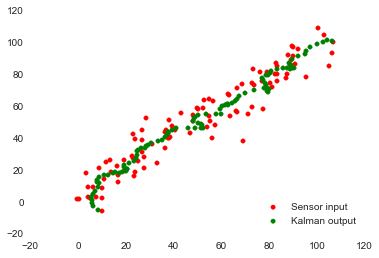

In [13]:
sql = """
        SELECT
           sensor1_x,
           sensor1_y
        FROM
           iot.plpy_kalman_input_one_sensor
        WHERE run_number = 1;
"""
df = psql.read_sql(sql, conn)

x = np.array(df.loc[0]['sensor1_x'])
y = np.array(df.loc[0]['sensor1_y'])

p1 = plt.scatter(x,y,color='r')

sql = """
        SELECT
            run_number,
            array_agg(x) as sensor1_x,
            array_agg(y) as sensor1_y
        FROM
            iot.plpy_kalman_output_one_sensor
        WHERE run_number = 1
        GROUP BY 1;
"""
df = psql.read_sql(sql, conn)

x_kf = np.array(df.loc[0]['sensor1_x'])
y_kf = np.array(df.loc[0]['sensor1_y'])

p2 = plt.scatter(x_kf,y_kf,color='g')
plt.legend((p1,p2), ('Sensor input', 'Kalman output'), loc = 'lower right')
plt.show()

In [14]:
conn.close()